In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## This code tests to make sure the models give the correct likelihood values


In [ ]:
from __future__ import division


import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise import constants as const

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler

pklfile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/NANOGrav_11yr_DE436.pickle'

with open(pklfile, 'rb') as f:
    psrs=pickle.load(f)
    
psr=psrs[0]

U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9  # clip first and last N observing epochs
t0min = np.floor(max(U[:,eps] * psr.toas/const.day))
t0max = np.ceil(max(U[:,-eps] * psr.toas/const.day))

ramp_pta = ee_models.model_ramp([psr], upper_limit=False, bayesephem=False,
                          Tmin_bwm=t0min, Tmax_bwm=t0max)


In [ ]:
noisefile = '/home/nima/nanograv/11yr/noisefiles/noisedict.json'
with open(noisefile, 'rb') as nfile:
    setpars = json.load(nfile)
    
ramp_pta.set_default_params(setpars)


In [ ]:
print(ramp_pta.params)
print(ramp_pta.params[-1])
#print(burst_pta.params)

In [ ]:
x0=np.hstack(p.sample() for p in ramp_pta.params)
print(x0)
print(ramp_pta.params[-1])
sign_sample = ramp_pta.params[-1].sample()
print(sign_sample)

In [ ]:
for p in ramp_pta.params:
    print(str(p) + '\n')

In [ ]:

sys.path.insert(0, '/home/nima/nanograv/custom_libs/enterprise/')
sys.path.insert(0, '/home/nima/nanograv/custom_libs/enterprise_extensions/')
sys.path.insert(0, '/home/nima/nanograv/custom_libs/PTMCMCSampler/')#let's try to calculate the associated amplitude and see if the ramp_pta
#gives the same answer

pos = psr.pos

costheta = x0[2]
log10_A = x0[3]
phi = x0[4]
pol=x0[5]
t0=x0[6]

h = 10 ** log10_A
theta=np.arccos(costheta)
t0 *= const.day

apc = utils.create_gw_antenna_pattern(pos, theta, phi)
fp, fc = apc[0], apc[1]

pol = np.cos(2 * pol) * fp + np.sin(2 * pol) * fc

print(pol*h)

In [ ]:
for p in ramp_pta.params:
    print(str(p) + '\n')

In [ ]:
gamma = x0[0]
intrinsic_log10_A = x0[1]
ramp_amp = pol*h
ramp_t0 = x0[6]

print(ramp_pta.get_lnlikelihood([gamma, intrinsic_log10_A, np.log10(ramp_amp), ramp_t0]))

# Scratch Space for re-implementing the likelihood table maker
I think that this code now mostly works for creating a likelihood-table with the correct likelihoods.
It now handles the parameter ordering more robustly and guarantees that the parameters it passes into likelihood calls are in the correct order.


In [ ]:
from __future__ import division

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise import constants as const

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler


from la_forge.core import Core, load_Core
from la_forge import rednoise
from la_forge.diagnostics import plot_chains

pklfile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/NANOGrav_11yr_DE436.pickle'
with open(pklfile, 'rb') as f:
    psrs=pickle.load(f)

noisefile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/noisefiles/noisedict.json'
with open(noisefile, 'rb') as f:
    setpars = json.load(f)
    
psr = psrs[0]
        

################### ==========================
### OG Fnc Body ### ==========================
################### ==========================



################
### SPACING ####
################

### Start by defining the spacing for each of these parameters

tmin = psr.toas.min() / const.day
tmax = psr.toas.max() / const.day

U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9  # clip first and last N observing epochs
t0min = np.floor(max(U[:,eps] * psr.toas/const.day))
t0max = np.ceil(max(U[:,-eps] * psr.toas/const.day))

Ts = np.linspace(t0min, t0max, num=100, endpoint=True)
time_name = 'ramp_t0'
time_spacing = '{},{},100'.format(t0min, t0max)

signs = np.linspace(-1,1,2)
sign_spacing = '-1,1,2'
sign_name = 'sign'


log10_burst_amplitudes = np.linspace(-17, -12, 50, endpoint=True) #grid points for the burst strain
burst_amp_spacing = '-17,-12,50'
burst_amp_name = 'ramp_log10_A'


log10_rn_amps = np.linspace(-20, -12, 80, endpoint=True) #grid points for the pulsar red noise
rn_amp_spacing = '-17,-12,50'
rn_amp_name = psr.name + '_red_noise_log10_A'


gammas = np.linspace(0, 7, 70, endpoint=True) #grid points for gamma'
gamma_spacing ='0,7,70'
gamma_name=psr.name + '_red_noise_gamma'

# Now we collect all of these in a dictionary for the pta so it can sample in whichever order it turns out to be
# This is because I'm worried that the order of the params is off, and we're sampling the wrong values for the params
# The dictionary will look something like:

# param_spacing_dict[par_name] = (actual_array, spacing_text)

param_spacing_dict = {}

param_spacing_dict[time_name] = (Ts, time_spacing) 
param_spacing_dict[sign_name] = (signs, sign_spacing)
param_spacing_dict[burst_amp_name] = (log10_burst_amplitudes, burst_amp_spacing)
param_spacing_dict[rn_amp_name] = (log10_rn_amps, rn_amp_spacing)
param_spacing_dict[gamma_name] = (gammas, gamma_spacing) 




outdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v3/'
if not os.path.exists(outdir + psr.name):
    os.mkdir(outdir + psr.name)



##################
#####   PTA   ####
##################

### Define the PTA 


pta = ee_models.model_ramp([psr],
                      upper_limit=False, bayesephem=False,
                      Tmin_bwm=t0min, Tmax_bwm=t0max)

pta.set_default_params(setpars)


outfile = outdir + psr.name + '/pars.txt'
with open(outfile, 'w') as f:
    for pname in pta.param_names:
        f.write(pname+';'+param_spacing_dict[pname][1]+'\n')


In [ ]:
print(pta.param_names)
print(param_spacing_dict['sign'])


In [ ]:
# Now that the parameters are defined, we need to build an x_0 in the right order to pass into the pta
# to evaluate the likelihood

idxs = []

for param in pta.param_names:
    idxs.append(len(param_spacing_dict[param][0]))
likelihoods = []
print(idxs)

for i4 in range(idxs[4]):
    for i3 in range(idxs[3]):
        for i2 in range(idxs[2]):
            for i1 in range(idxs[1]):
                for i0 in range(idxs[0]):
                    xs = []
                    xs.append(param_spacing_dict[pta.param_names[0]][0][i0])
                    xs.append(param_spacing_dict[pta.param_names[1]][0][i1])
                    xs.append(param_spacing_dict[pta.param_names[2]][0][i2])
                    xs.append(param_spacing_dict[pta.param_names[3]][0][i3])
                    xs.append(param_spacing_dict[pta.param_names[4]][0][i4])
                    
                    likelihoods.append(pta._lnlikelihood.__call__(xs))
    
                                 
                    



In [ ]:
from sys import getsizeof
print(getsizeof(likelihoods)/(1024)/1024/1024)

In [ ]:
type(pta._lnlikelihood)

In [ ]:
np.savetxt('/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v3/B1855+09/B1855+09_lookup.txt', likelihoods)

## This code uses lookup tables to run a factorized likelihood BWM Ramp estimation

In [ ]:
from __future__ import division


import sys

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp
import time

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise import constants as const

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LookupLikelihood
from enterprise.signals.signal_base import LogLikelihood

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

pklfile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/NANOGrav_11yr_DE436.pickle'
with open(pklfile, 'rb') as f:
    psrs=pickle.load(f)
    
for each in psrs:
    if each.name == "B1855+09":
        psr = each

noisefile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/noisefiles/noisedict.json'
lookupdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/'
U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9  # clip first and last N observing epochs
t0min = np.floor(max(U[:,eps] * psr.toas/const.day))
t0max = np.ceil(max(U[:,-eps] * psr.toas/const.day))

pta = ee_models.model_ramp([psr], LookupLikelihood, lookupdir=lookupdir, upper_limit=False, bayesephem=False,
                          Tmin_bwm=t0min, Tmax_bwm=t0max)



outdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_factorized_v4/'
np.savetxt(outdir+'pars.txt',list(map(str, pta.param_names)), fmt='%s')
np.savetxt(outdir+'priors.txt',list(map(lambda x: str(x.__repr__()), pta.params)), fmt='%s')


In [ ]:
noisefile = '/home/nima/nanograv/11yr/noisefiles/noisedict.json'
with open(noisefile, 'rb') as nfile:
    setpars = json.load(nfile)

pta.set_default_params(setpars)


In [ ]:
x0 = np.hstack(p.sample() for p in pta.params)
print(pta.params)

In [ ]:
pta.get_lnlikelihood(x0)
print(type(pta._lnlikelihood))
print(pta.get_lnlikelihood(x0))

In [ ]:
ndim = len(x0)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1**2)

np.savetxt(outdir+"pars.txt",list(map(str, pta.param_names)), fmt='%s')
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov,  outDir=outdir, resume=False)

In [ ]:
jp = ee_sampler.JumpProposal(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 30)

sampler.sample(x0, int(3e5), SCAMweight=30, AMweight=50, DEweight=0)

In [ ]:
pta.get_lnlikelihood(x0)

## Postprocessing the Above


In [ ]:
from la_forge.core import Core
from la_forge.diagnostics import plot_chains

In [ ]:
chaindir_factorized = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_factorized_v4/'
chaindir_noramp = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_pta_no_ramp/'
#chaindir_standard_bwm = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/burst_pta_paul_sgl/'
chaindir_standard_ramp = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/sgl_psr_run/ramp_pta_jerry_sgl/'
core_factorized=Core(label="B1855 BWM Factorized", chaindir=chaindir_factorized, burn=0)
core_noramp = Core(label="B1855 Ram PTA, A=0", chaindir=chaindir_noramp, burn=0)
#core_standard_bwm=Core(label="B1855 BWM Standard BWM Run", chaindir = chaindir_standard_bwm, burn=0)
core_standard_ramp=Core(label="B1855 Ramp Standard BWM Run", chaindir = chaindir_standard_ramp, burn=0)

In [ ]:
plot_chains(core_factorized, hist=False, suptitle= "Factorized likelihood run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
plot_chains(core_noramp, hist=False, suptitle= "A=0 run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
#plot_chains(core_standard_bwm, hist=False, suptitle= "Standard burst bwm run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
plot_chains(core_standard_ramp, hist=False, suptitle= "Standard burst ramp run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])

In [ ]:
plot_chains(core_factorized, hist=True, suptitle= "Factorized likelihood run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
plot_chains(core_noramp, hist=True, suptitle= "A=0 Run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])

#plot_chains(core_standard_bwm, hist=True, suptitle= "Standard burst bwm run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])
plot_chains(core_standard_ramp, hist=True, suptitle= "Standard burst ramp run",exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])

# Miscellaneous Scratch Work (comparing different runs in depth mostly)

In [ ]:
indiv_log10_As = core_factorized.get_param("B1855+09_red_noise_log10_A")
signs = core_factorized.get_param("sign")

positive_idxs = []
negative_idxs = []
for idx in range(len(signs)):
    if signs[idx] > 0:
        positive_idxs.append(idx)
    else:
        negative_idxs.append(idx)

positive_log10_As = []
negative_log10_As = []
for idx in positive_idxs:
    positive_log10_As.append(indiv_log10_As[idx])

for idx in negative_idxs:
    negative_log10_As.append(indiv_log10_As[idx])

plt.hist(positive_log10_As, bins=30, fill=False)


In [ ]:
plt.hist(negative_log10_As, bins=30, fill=False)

In [ ]:
# We notice in the above two plots of the standard runs, the ramp_log10_A is pretty much preferring -14 to -13.
# Let's excise the elements of the chains where this happens and see if the lookup table agrees

log10_As_chain = core_standard_ramp.get_param("ramp_log10_A")
idxs = []
for link_idx in range(len(log10_As_chain)):
    if log10_As_chain[link_idx] > -14 and log10_As_chain[link_idx] < -13:
        idxs.append(link_idx)

pref_As_chain = []
for link_idx in range(len(core_standard_ramp.chain)):
    if link_idx in idxs:
        pref_As_chain.append(core_standard_ramp.chain[link_idx])
    


In [ ]:
## lnprior is now actually lnlike, at index -3, thanks to the addition of the temperature in the chain 
## TODO: Have to fix this because it's actually causing unwanted side effects in la_forge

xs = np.array(pref_As_chain)[:, 0:5]
lnlikes = np.array(pref_As_chain)[:, -3]
#print(xs)
#print(lnlikes)

print(max(lnlikes))
print(max(likelihoods))

#These give the same-ish number.. this looks like it works, but I think it's the same as before!

In [ ]:
# Let's make some corner plots of A and gamma
import corner

Arns = core_standard_ramp.get_param("B1855+09_red_noise_log10_A")
gammas = core_standard_ramp.get_param("B1855+09_red_noise_gamma")

data=np.vstack([Arns, gammas]).T
print(data)
corner.corner(data)

In [ ]:
import copy

factorized_signs = core_factorized.get_param("sign")
idxs = []
for i in range(len(factorized_signs)):
    if factorized_signs[i] < 0:
        idxs.append(i)
        
        
factorized_t0s = core_factorized.get_param("ramp_t0")

negative_signed_t0s = []
positive_signed_t0s = copy.deepcopy(factorized_t0s)

print(len(positive_signed_t0s), len(idxs))
positive_signed_t0s = np.delete(positive_signed_t0s, idxs)

      
for idx in idxs:
    negative_signed_t0s.append(factorized_t0s[idx])
    
print(len(negative_signed_t0s) + len(positive_signed_t0s))
print(len(factorized_t0s))



In [ ]:
plt.hist(negative_signed_t0s, bins=30)
plt.title("burst epochs with negative sign")

In [ ]:
plt.hist(positive_signed_t0s, bins=30)
plt.title("burst epochs with positive sign")

# Trying to implement the multi-pulsar BWM sampling PTA

In [ ]:
from __future__ import division


import sys

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp
import time

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import selections
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LookupLikelihood
from enterprise.signals.signal_base import LogLikelihood

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

#Start by loading the pulsars and noisedict
pklfile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/NANOGrav_11yr_DE436.pickle'
noisefile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/noisefiles/noisedict.json'

with open(pklfile, 'rb') as f:
    psrs = pickle.load(f)

with open(noisefile, 'rb') as f:
    noisedict = json.load(f)
  

In [ ]:
################
# Building PTA #
################

# Get the max and minimum t0s for the pta
# We need to decide how to treat burst epochs that are out of range of
# some of the pulsars, since we have different baselines

tmin = np.min([p.toas.min() for p in psrs])
tmax = np.max([p.toas.max() for p in psrs])
Tspan = tmax - tmin


# Build the white noise model
# These parameters will be fixed
selection = selections.Selection(selections.by_backend)

efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant()

ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

wn = ef + eq + ec #We're including ecorr bc these are all NANOGrav backend psrs

"""
In this iteration, we're going to try a global set of parameters for bwm
that get fed into each pulsar. Not sure how we're going to do this in the
actual code, but for now, I'll try to structure things this way.
For this run, we want the following parameters to vary:
      Globally: [bwm_costheta, bwm_phi, bwm_psi, bwm_h0, bwm_t0]
      per pulsar: [psr_red_noise_log10_A, psr_red_noise_gamma]
For a total of 5 + 4*Npsr parameters. Furthermore, note that the format of the names above is the one that reflects
the naming conventions I've used in the lookup tables, so for now we just have to use these.

Furthermore, the 5 global parameters will be fed into each pulsar to inform that
particular pulsar's bwm parameters (we need to explicitly calculated A, t0 and sign for each
pulsar given the global parameters during a particular step)

"""


# Build the red noise model that will exist for each pulsar
rn_log10_A = parameter.Uniform(-18, -12) #These bounds on rn_l10A reflect the lookup-table limits
rn_gamma = parameter.Uniform(0, 7)

rn_pl = utils.powerlaw(log10_A=rn_log10_A, gamma=rn_gamma)
rn = gp_signals.FourierBasisGP(rn_pl, components=30, Tspan=Tspan)

# Build the global BWM parameters
bwm_costheta = parameter.Uniform(-1, -1)('bwm_costheta')
bwm_phi = parameter.Uniform(0, 2*np.pi)('bwm_phi')
bwm_psi = parameter.Uniform(0, np.pi)('bwm_pol')
bwm_h0 = parameter.Uniform(-18, -12)('bwm_h0')
bwm_t0 = parameter.Uniform(t0min, t0max)('bwm_t0')

bwm_wf = utils.bwm_delay(log10_h=bwm_h0, t0=bwm_t0,
                            cos_gwtheta=bwm_costheta, gwphi=bwm_phi, gwpol=bwm_psi)
bwm = deterministic_signals.Deterministic(bwm_wf, name='bwm')

# Build timing model
tm = gp_signals.TimingModel(use_svd=False)

s = tm + wn + rn + bwm

# Apply the complete model to each pulsar
models = []
for p in psrs:
    models.append(s(p))
    
# Now construct the PTA
lookupdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/'
pta = signal_base.PTA(models, lnlikelihood=LookupLikelihood, lookupdir=lookupdir)



# Actual random tomfoolery

In [ ]:
psrs = []
noise_path = '/home/nima/nanograv/15yr_prelim1/noisefiles/noisedict.json'
pkl_path = '/home/nima/nanograv/15yr_prelim1/nano15yr_prelim1_DE438_BIPM2018_45psrs.pkl'

with open(pkl_path, 'rb') as f:
    psrs=pickle.load(f)

#Load in noise parameters
with open(noise_path, 'r') as f:
    noise_params = json.load(f)
    
pta=ee_models.model_general(psrs, common_psd='powerlaw', red_psd='powerlaw', common_components=5, red_components=30)


In [ ]:
pta.set_default_params(noise_params)

In [ ]:
print(pta._commonsignals)
print(pta.param_names)

In [ ]:
print(pta.signals['B1855+09_gw'].get_basis.modes)

In [8]:
psrname = 'B1937+21'
lookup = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/{}/{}_lookup.txt'.format(psrname, psrname)

f = open(lookup, 'rb')

In [9]:
bytes_per_line = 0
out = []
f.seek(0,0)
while f.read(1) != b'\n':
    bytes_per_line += 1
print(bytes_per_line)
f.seek(0,0)
print(f.read(bytes_per_line +1))
f.read()

19
b'197111.096244125336\n'


In [10]:
f.seek(0,0)
line_no = 0
while True:
    f.seek((bytes_per_line+1)*line_no, 0)
    num = float(f.read(bytes_per_line).decode())
    line_no+=1

ValueError: could not convert string to float: '0380.932440489531\n9'

In [18]:
line_start = line_no - 10
line_end = line_no + 10

out = []

f.seek((bytes_per_line+1)*line_start,0)

out = f.read((bytes_per_line+1)*20)
print(out)

b'199682.301539704204\n199682.092635020614\n199681.866780921817\n199681.623727083206\n199681.363259628415\n199681.085206136107\n199680.789437279105\n199680.475870132446\n199680.144470170140\n90380.932410389185\n90380.932440489531\n90380.932476490736\n90380.932520568371\n90380.932573288679\n90380.932636678219\n90380.932714045048\n90380.932807683945\n90380.932922720909\n90380.933062642813\n90380.933234810829\n90380.93344'


In [ ]:
f.seek((bytes_per_line+1) * line_no, 0)
string = f.read(bytes_per_line).decode()

In [25]:
print(out.decode())

199682.301539704204
199682.092635020614
199681.866780921817
199681.623727083206
199681.363259628415
199681.085206136107
199680.789437279105
199680.475870132446
199680.144470170140
90380.932410389185
90380.932440489531
90380.932476490736
90380.932520568371
90380.932573288679
90380.932636678219
90380.932714045048
90380.932807683945
90380.932922720909
90380.933062642813
90380.933234810829
90380.93344


In [75]:
float1 = 199682.301539704204
float2 = 90380.93244048950000

print(str(float1).rjust(18))
print(str(float2).rjust(18))

str1 = "{:.12f}".format(float1)
str2 = "{:.12f}".format(float2)

print(str1)
print(str2)

float("  123.4")

 199682.3015397042
  90380.9324404895
199682.301539704204
90380.932440489501


123.4

# Scratch for testing multi-psr bwm search

In [76]:
from __future__ import division


import sys

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp
import time

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import selections
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LookupLikelihood
from enterprise.signals.signal_base import LogLikelihood

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

def get_pos(psrname, psrs):
    for psr in psrs:
        if psr.name == psrname:
            mypsr = psr
    
    return mypsr.pos

def bwm_to_ramp_condenser(xs, psr, pta_param_names):
    # We want to condense:
    # bwm_costheta, bwm_log10_A, bwm_phi, bwm_pol, bwm_t0, the global parameters
    # This function should return a new vector xs, with bwm_* gone, and turned into ramp_* and sign
    # in the following order: ramp_log10_A, ramp_t0, sign
    
    #start by retrieving all the relevant numbers from xs
    pos=psr.pos
    cos_gwtheta = xs[pta_param_names.index("bwm_costheta")]
    log10_h = xs[pta_param_names.index("bwm_log10_A")]
    gwphi = xs[pta_param_names.index("bwm_phi")]
    gwpol = xs[pta_param_names.index("bwm_pol")]
    t0 = xs[pta_param_names.index("bwm_t0")]
    
    #print("{}\n{}\n{}\n{}\n{}\n{}".format(pos, cos_gwtheta, log10_h, gwphi, gwpol, t0))
    
    #refer to enterprise.utils.bwm_delay for this calculation
    h = 10**log10_h
    gwtheta = np.arccos(cos_gwtheta)
    
    apc=utils.create_gw_antenna_pattern(pos, gwtheta, gwphi)
    fp, fc = apc[0], apc[1]
    pol=np.cos(2*gwpol) * fp + np.sin(2 * gwpol) * fc
    #sign of memory is dictated by this polarization calculation, the strain will always be positive
    if pol < 0:
        sign = -1
    else:
        sign = 1
    
    ramp_log10_A = np.log10(abs(h*pol))
     
    # Now the amplitude is just pol * h, and t0 remains the same
    # We need to create the new xs array for the lookups  
    # start building the return by copying everything over before the condensed parameters
    new_xs = []
    new_param_names = []
    for i in range(pta_param_names.index("bwm_costheta")):
        new_xs.append(xs[i])
        new_param_names.append(pta_param_names[i])
        
    
    #copy over new stuff
    new_xs.append(ramp_log10_A)
    new_xs.append(t0)
    new_xs.append(sign)
    
    new_param_names.append("ramp_log10_A")
    new_param_names.append("ramp_t0")
    new_param_names.append("sign")
    
    return new_xs, new_param_names

pklfile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/NANOGrav_11yr_DE436.pickle'
noisefile = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/noisefiles/noisedict.json'
lookupdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/'

with open(pklfile, 'rb') as f:
    psrs=pickle.load(f)

#Load in noise parameters
with open(noisefile, 'r') as f:
    noise_params = json.load(f)

mypsrs = [psrs[0], psrs[2]]



amp_spacing = '-18,-12,60'
log10_amps = np.linspace(-18, -12, 60, endpoint=True)

gamma_spacing ='0,7,70'
gammas = np.linspace(0, 7, 70, endpoint=True)

t0min = min([p.toas.min() for p in mypsrs])
t0max = max([p.toas.max() for p in mypsrs])

ramp_pta = ee_models.model_ramp(mypsrs, LookupLikelihood, lookupdir=lookupdir,
                          upper_limit=False, bayesephem=False,
                          Tmin_bwm=t0min, Tmax_bwm=t0max, logmin=min(log10_amps), logmax=max(log10_amps))

burst_pta = ee_models.model_bwm(mypsrs, LookupLikelihood, lookupdir=lookupdir,
                                upper_limit=False, bayesephem=False,
                                Tmin_bwm=t0min, Tmax_bwm=t0max,logmin=min(log10_amps), logmax=max(log10_amps))

No noise dictionary provided!...
No noise dictionary provided!...


In [77]:
mypsrs[0].pos

array([ 0.23527603, -0.9573531 ,  0.16769088])

In [78]:
ramp_pta.set_default_params(noise_params)
burst_pta.set_default_params(noise_params)

INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_efac to 1.15373
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_efac to 1.12092
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_efac to 1.08632
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_efac to 1.37768
INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_log10_equad to -8.87356
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_log10_equad to -6.17217
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_log10_equad to -6.50338
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_log10_equad to -6.53848
INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_log10_ecorr to -7.31698
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_log10_ecorr to -6.31615
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_log10_ecorr to -6.09398
INFO: enterprise.signals.signal_base: Setting B185

In [79]:
burst_pta._lnlikelihood.condenser = bwm_to_ramp_condenser
burst_pta._lnlikelihood.condenser

Looking for parfile in: /home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/B1855+09/pars.txt
Looking for parfile in: /home/nima/nanograv/11yr_burst_factorizedlikelihood/single_psr_lookup_v4/B1953+29/pars.txt


<function __main__.bwm_to_ramp_condenser(xs, psr, pta_param_names)>

In [80]:
sampling_outdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/multi_psr_runs/factorized_v1/'
np.savetxt(sampling_outdir+'pars.txt',list(map(str, burst_pta.param_names)), fmt='%s')
np.savetxt(sampling_outdir+'priors.txt',list(map(lambda x: str(x.__repr__()), burst_pta.params)), fmt='%s')

In [82]:
x0 = np.hstack(p.sample() for p in burst_pta.params)
ndim = len(x0)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1**2)
sampler = ptmcmc(ndim, burst_pta.get_lnlikelihood, burst_pta.get_lnprior, cov,  outDir=sampling_outdir, resume=False)

jp = ee_sampler.JumpProposal(burst_pta)
sampler.addProposalToCycle(jp.draw_from_prior, 30)

sampler.sample(x0, int(3e5), SCAMweight=30, AMweight=50, DEweight=0)

/home/nima/anaconda3/envs/enterprise/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Finished 3.33 percent in 15.272514 s Acceptance rate = 0.526556Adding DE jump with weight 0
Finished 99.67 percent in 455.030488 s Acceptance rate = 0.482027
Run Complete


Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 7475
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


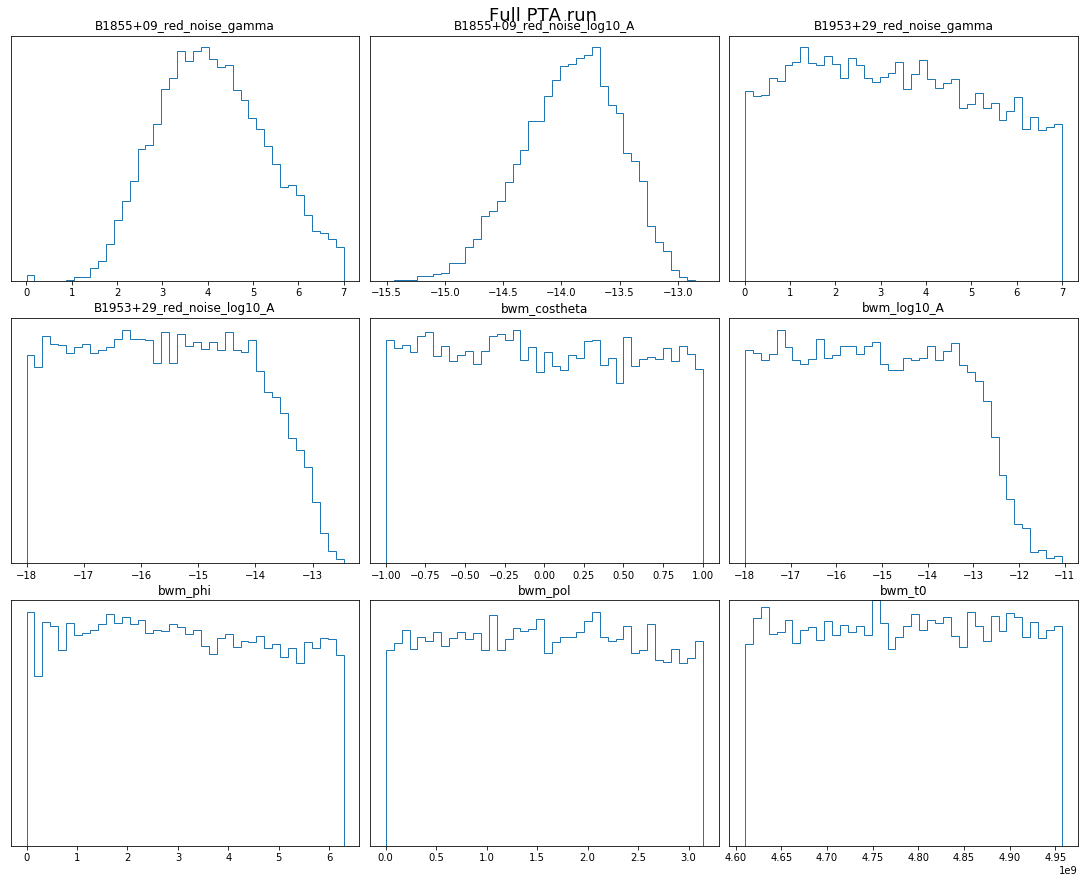

In [83]:
from la_forge.core import Core
from la_forge.diagnostics import plot_chains

chaindir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/multi_psr_runs/factorized_v1/'
core = Core(label='condensed factorized', chaindir=chaindir)
plot_chains(core, hist=True, density=True, suptitle='Full PTA run', exclude=["lnlike", "chain_accept", "pt_chain_accept", "lnprior"])

In [84]:
float("1.2345657e10")

12345657000.0